# Data Preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pickle
from sklearn.preprocessing import  StandardScaler
df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\sitharth\DDoS-attack-detection-using-HTTP-packet-clustering-pattern-master\WP_Dataset\wplogs.csv")
df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14469 entries, 0 to 14468
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   @timestamp           14469 non-null  object 
 1   @timestamp.1         14469 non-null  object 
 2   _id                  14469 non-null  object 
 3   bytes                14469 non-null  object 
 4   clientip             14469 non-null  object 
 5   geoip.country_code3  11535 non-null  object 
 6   httpversion          14453 non-null  float64
 7   request              14453 non-null  object 
 8   response             14469 non-null  int64  
 9   useragent.device     14469 non-null  object 
 10  useragent.name       14469 non-null  object 
 11  useragent.os         14469 non-null  object 
 12  verb                 14453 non-null  object 
 13  useragent.os_name    14469 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 1.5+ MB


# Data Preprocessing

In [7]:
!pip install pandas scikit-learn

In [9]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Convert timestamp columns to datetime
df['@timestamp'] = pd.to_datetime(df['@timestamp'], format='%b %d, %Y @ %H:%M:%S.%f')
df['@timestamp.1'] = pd.to_datetime(df['@timestamp.1'], format='%b %d, %Y @ %H:%M:%S.%f')

# Ensure the columns are in datetime format
df['@timestamp'] = pd.to_datetime(df['@timestamp'])
df['@timestamp.1'] = pd.to_datetime(df['@timestamp.1'])

# Convert 'bytes' column to numeric, handling errors explicitly
try:
    df['bytes'] = pd.to_numeric(df['bytes'])
except ValueError as e:
    print(f"Error converting 'bytes' to numeric: {e}")
    # Optionally, you can fill non-numeric values with NaN or a default value
    df['bytes'] = pd.to_numeric(df['bytes'], errors='coerce')

# Drop rows with missing values in specific columns
df.dropna(subset=['httpversion', 'request', 'verb'], inplace=True)

# Filter out rows where 'clientip' is '127.0.0.1'
df = df[df['clientip'] != '127.0.0.1']

# Fill missing values in 'geoip.country_code3' with 'unknown'
df['geoip.country_code3'] = df['geoip.country_code3'].fillna('unknown')

# One-hot encode categorical columns
categorical_cols = ['useragent.device', 'useragent.name', 'useragent.os', 'verb', 'useragent.os_name']
encoder = OneHotEncoder(handle_unknown='ignore')  # Remove `sparse=False`
encoded_cols = encoder.fit_transform(df[categorical_cols])

# Convert the encoded columns to a DataFrame
encoded_cols_df = pd.DataFrame(encoded_cols.toarray(), columns=encoder.get_feature_names_out(categorical_cols))

# Drop the original categorical columns and concatenate the encoded ones
df.drop(categorical_cols, axis=1, inplace=True)
df = pd.concat([df, encoded_cols_df], axis=1)

# Display the first few rows of the DataFrame
print(df.head())

Error converting 'bytes' to numeric: Unable to parse string "15,003" at position 1
            @timestamp        @timestamp.1                   _id  bytes  \
50 2020-06-20 14:45:21 2020-06-20 14:45:21  Dlbk1HIBxLQmqGLLs2PB  410.0   
52 2020-06-20 14:45:21 2020-06-20 14:45:21  EFbk1HIBxLQmqGLLs2PB    NaN   
70 2020-06-20 14:45:03 2020-06-20 14:45:03  -Vbk1HIBxLQmqGLLs2LB    NaN   
71 2020-06-20 14:45:03 2020-06-20 14:45:03  -lbk1HIBxLQmqGLLs2LB    NaN   
72 2020-06-20 14:45:03 2020-06-20 14:45:03  -1bk1HIBxLQmqGLLs2LB    NaN   

           clientip geoip.country_code3  httpversion  \
50   195.54.160.135             unknown          1.1   
52   195.54.160.135             unknown          1.1   
70  103.224.146.167                  IN          1.1   
71  103.224.146.167                  IN          1.1   
72  103.224.146.167                  IN          1.1   

                                              request  response  \
50  /vendor/phpunit/phpunit/src/Util/PHP/eval-stdi...     301.

# K-means Clustering

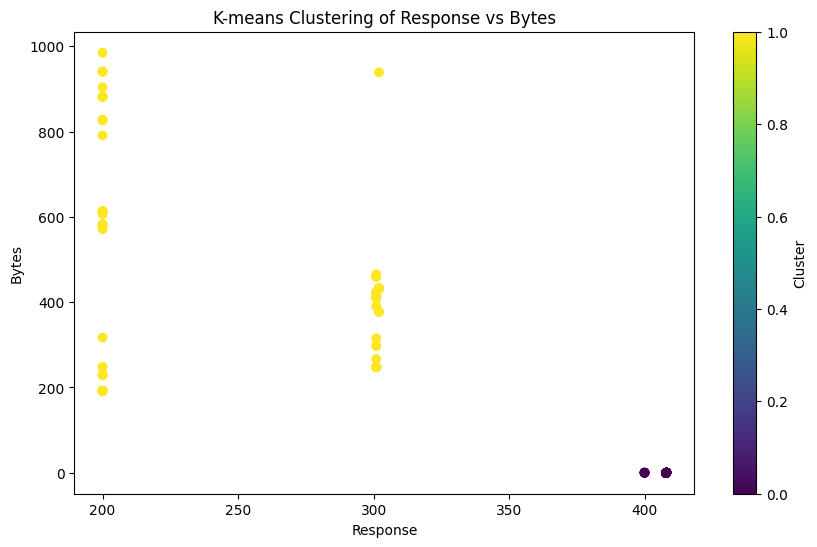

In [11]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Drop rows with missing values in 'response' and 'bytes'
df.dropna(subset=['response', 'bytes'], inplace=True)

# Convert timestamp columns to datetime
df['@timestamp'] = pd.to_datetime(df['@timestamp'])
df['@timestamp.1'] = pd.to_datetime(df['@timestamp.1'])

# Ensure 'bytes' column is treated as a string before replacing commas
df['bytes'] = df['bytes'].astype(str).str.replace(',', '').astype(float)

# Select features for clustering
X = df[['response', 'bytes']]

# Perform K-means clustering
kmeans = KMeans(n_clusters=2)  
kmeans.fit(X)

# Add cluster labels to the DataFrame
df['cluster'] = kmeans.labels_

# Get unique client IPs in cluster 0
cluster_0_ips = df[df['cluster'] == 0]['clientip'].unique()

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(df['response'], df['bytes'], c=df['cluster'], cmap='viridis')
plt.title('K-means Clustering of Response vs Bytes')
plt.xlabel('Response')
plt.ylabel('Bytes')
plt.colorbar(label='Cluster')
plt.show()

# Ip-address potenital for Ddos-attack

In [12]:
threshold_per_byte = 1000
timestamp_data = []
distinct_ips = set()

for ip in cluster_0_ips:
    ip_data = df[df['clientip'] == ip]
    for _, row in ip_data.iterrows():
        bytes_transfer = int(row['bytes'])
        if bytes_transfer >= threshold_per_byte:
            timestamp_data.append({
                'clientip': ip,
                '@timestamp': row['@timestamp'],
                'bytes': bytes_transfer
            })
            distinct_ips.add(ip)

ip_frequency = df['clientip'].value_counts()
max_frequency_ips = ip_frequency[ip_frequency == ip_frequency.max()].index

filtered_timestamp_data = []
for data in timestamp_data:
    if data['clientip'] in max_frequency_ips:
        filtered_timestamp_data.append(data)

timestamp_df = pd.DataFrame(filtered_timestamp_data)

print("IP addresses with potential DDoS Attack")
print(list(max_frequency_ips))

print("\nTimestamp Data:")
print(timestamp_df)



IP addresses with potential DDoS Attack
['103.224.146.167']

Timestamp Data:
Empty DataFrame
Columns: []
Index: []


# Attack phase Visualisation

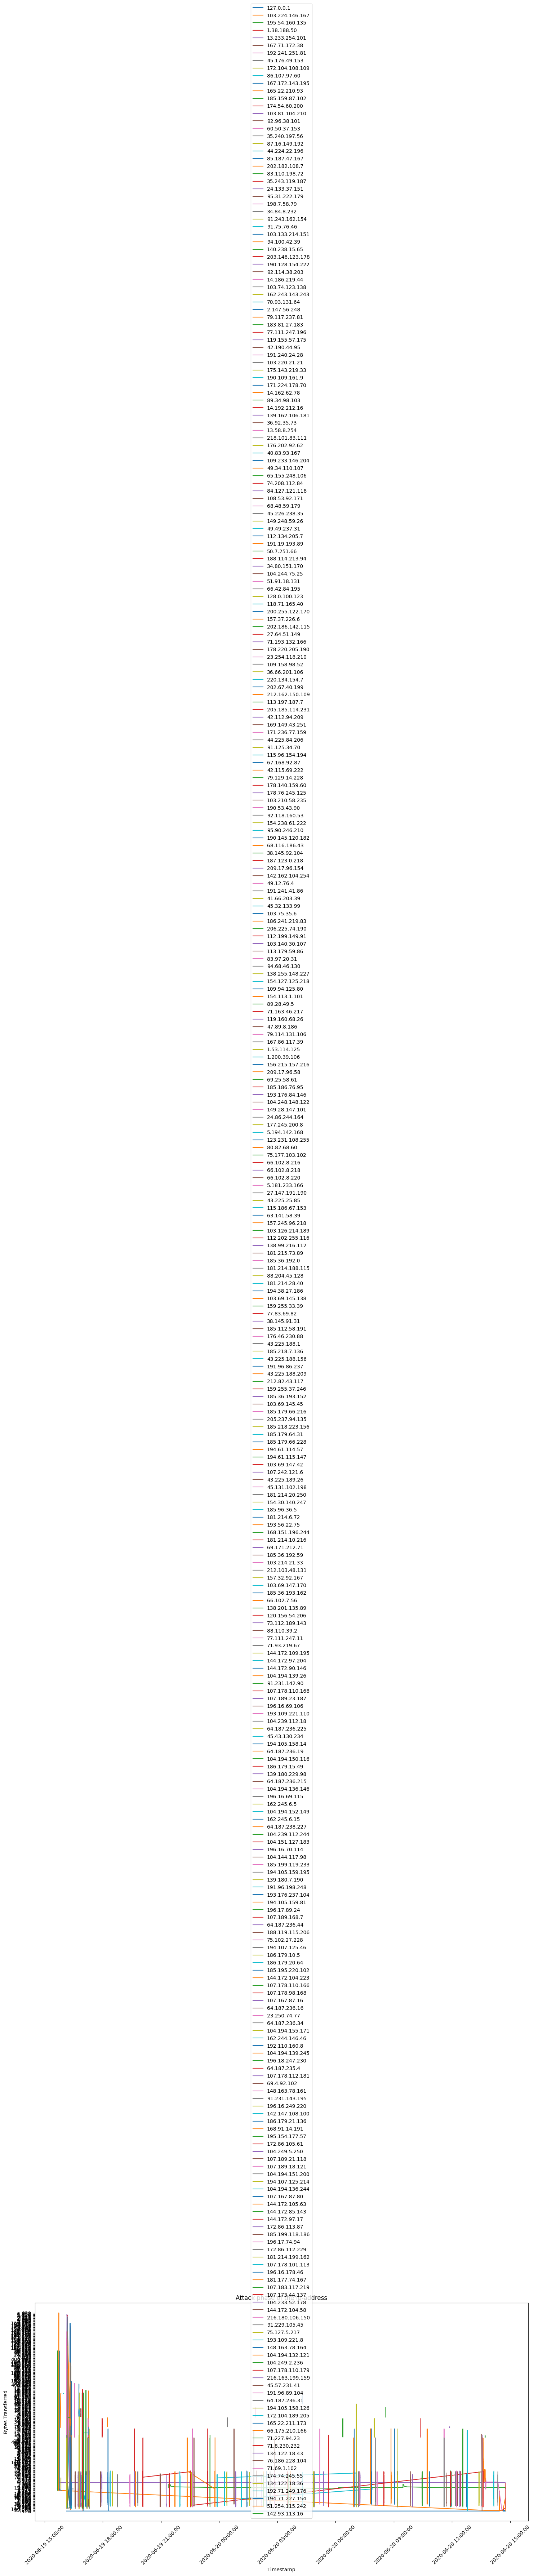

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the DataFrame (replace with the actual file path)
try:
    timestamp_df = pd.read_csv(r'C:\Users\HP\OneDrive\Desktop\sitharth\DDoS-attack-detection-using-HTTP-packet-clustering-pattern-master\WP_Dataset\wplogs.csv')
except Exception as e:
    raise ValueError(f"Error loading the file: {e}")

# Debugging: Check if the DataFrame is empty
if timestamp_df.empty:
    raise ValueError("The DataFrame is empty. Please check the data source.")

# Debugging: Check if the '@timestamp' column exists
if '@timestamp' not in timestamp_df.columns:
    raise KeyError(f"Column '@timestamp' not found in the DataFrame. Available columns: {timestamp_df.columns}")

# Convert '@timestamp' to datetime with the correct format
timestamp_df['@timestamp'] = pd.to_datetime(timestamp_df['@timestamp'], format='%b %d, %Y @ %H:%M:%S.%f')

# Debugging: Check if 'clientip' and 'bytes' columns exist
required_columns = ['clientip', 'bytes']
for col in required_columns:
    if col not in timestamp_df.columns:
        raise KeyError(f"Column '{col}' not found in the DataFrame. Available columns: {timestamp_df.columns}")

# Create the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot data for each unique IP address
distinct_ips = timestamp_df['clientip'].unique()  # Get unique IPs
for ip in distinct_ips:
    ip_data = timestamp_df[timestamp_df['clientip'] == ip]
    ax.plot(ip_data['@timestamp'], ip_data['bytes'], label=ip)

# Customize the plot
ax.set_title('Attack phase of the Ip-address')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Bytes Transferred')

# Format the x-axis to display timestamps
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.legend()
plt.show()

# Silhoutte_score

In [20]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(X, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.9875122053421247
